### Primal Slab SVM
Let $K \in R^{m \times m}$ and $K_{ij} = \texttt{kernel}(x_i,x_j)$ and $K_{i}$ the $i^{th}$ column of $K$

Then Primal Minimization Objective:
$$\min_{\beta \in R^m} \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta)$$

Let $F$ be the objective function.
$$F(\beta) = \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta)$$


Gradient:
$$\vec\nabla F(\beta) = 2K\beta + \frac {1}{\nu m} \sum_i K_i \circ \frac{d}{d\beta}\texttt{loss}(K_i^T \beta)$$

Hessian:
$$H = 2K + \frac {1}{\nu m} \sum_i \left( K_i \circ K_i \right) \circ \frac{d^2}{(d\beta)^2}\texttt{loss}(K_i^T \beta)$$

We consider losses:
$$\texttt{loss}_{hinge}(t) = \max(~0,~ |~\rho - t~| - \delta ~)$$
$$\texttt{loss}_{square-hinge}(t) = \max(~0,~ |~\rho - t~| - \delta ~)^2$$


Loss Gradients:
$$\frac{d}{dt}\texttt{loss}_{hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-1, & \mbox{if } ~\rho - t~ \gt \delta  \\
1, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d}{dt}\texttt{loss}_{square-hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-2\left(\rho-t-\delta\right), & \mbox{if } ~\rho - t~ \gt \delta  \\
2\left(-\rho+t-\delta\right), & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$


Loss Hessians:
$$\frac{d^2}{(dt)^2}\texttt{loss}_{hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
0, & \mbox{if } ~\rho - t~ \gt \delta  \\
0, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d^2}{(dt)^2}\texttt{loss}_{square-hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
2, & \mbox{if } ~\rho - t~ \gt \delta  \\
2, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

Evaluation:
$$ \langle \Phi(x), w\rangle = \sum_k \beta_k k(x_k, x) $$

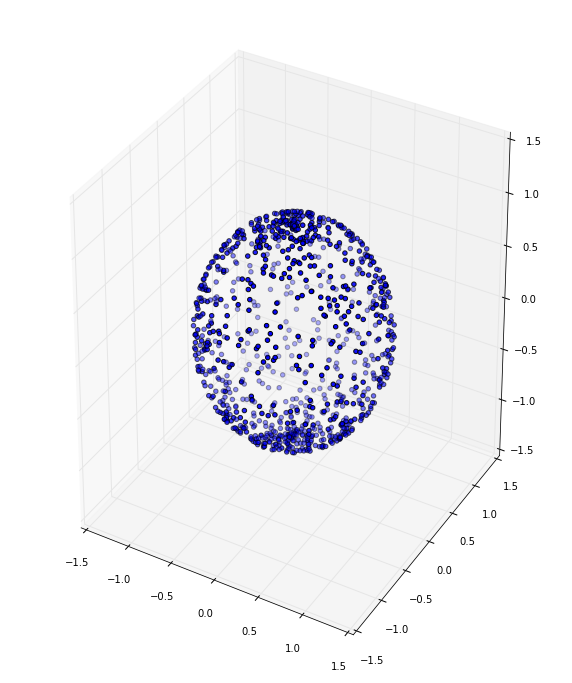

pre_comp_K: 7.89405202866
obj 100000.0
obj 5114.76132786
obj 369.285954026
obj 26.1366731139
obj 2.1301523763
obj 0.205119877996
obj 0.0712671399599
obj 0.063497437673
obj 0.0109516592015
obj 0.00672513242352
obj 0.00187543612016
obj 0.000877936321743
obj 0.000812666758015
obj 0.000714576476776
obj 8.66487272089e-05
grad_des: 187.740150213
Newton Desc iterations 14


/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:189: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [13]:
%matplotlib inline

import numpy as np
from numpy import linalg, random, ones, zeros
from numpy.linalg import norm
from sklearn.cross_validation import train_test_split
import mosek
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import time 
from collections import namedtuple

v=.00001
delta = 0.0
sigma = 100
rho = 1
max_iter = 100
initial_step_size = .1
timer_thresh = .1
ep = .000001
# loss_type = 'hinge'
loss_type = 'square-hinge'
method = ''
x=np.zeros((0))
K=np.zeros((0))
K_inv=np.zeros((0))
points_count = 1000
points_std_from_surface = 0.0

def H(beta,loss_vect_list):
    start = time.time()
    ret = 2*K
    if loss_type == 'hinge':
        pass
    elif loss_type == 'square-hinge':
        ret += 2/(v*len(x))*np.sum(K[:,loss_vect_list]*K[:,loss_vect_list], axis=0)
    else:
        for i in range(len(ret)):
            ret += 1/(v*len(x))*K[:,i]*K[:,i]*loss_der_der(np.dot(K[:,i],beta))
    end = time.time()
    if end - start > timer_thresh:
        print 'H:',end - start
    return ret

def loss_der_der(t):
    if loss_type == 'hinge':
        return 0
    if loss_type == 'square-hinge':
        if abs(rho - t) < delta:
            return 0
        else:
            return 2
    raise Exception(loss_type,t,rho,delta)

def loss_der(t):
    if loss_type == 'hinge':
        if abs(rho - t) <= delta:
            return 0
        if rho - t > delta:
            return -1
        if -rho + t > delta:
            return 1
    if loss_type == 'square-hinge':
        if abs(rho - t) <= delta:
            return 0
        if rho - t > delta:
            return -2*(rho - t - delta)
        if -rho + t > delta:
            return 2*(-rho + t - delta)
    raise Exception(loss_type,t,rho,delta)
        
def obj_grad(beta):
    start = time.time()
    ret = 2*np.dot(K,beta)
    for i in range(len(ret)):
        ret += 1/(v*len(x))*K[:,i]*loss_der(np.dot(K[:,i],beta))
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_grad:',end - start
    return ret

def kernel(x1,x2):
    return math.exp(-1*math.pow(norm(x1-x2),2
                               )/(2*math.pow(sigma, 2)))

def kernel_vect(x_list,x2):
    return np.exp(-1*np.power(norm(x_list-x2,axis=1),2 )/(2*math.pow(sigma, 2)))

def loss(t):
    if loss_type == 'hinge':
        return max(0, abs(rho - t) - delta )
    if loss_type == 'square-hinge':
        return max(0, abs(rho - t) - delta )**2

def obj_funct(beta):
    start = time.time()
    m = len(x)
    loss_sum = 0
    for i in range(len(x)):
        loss_sum += loss(np.dot(K[:,i],beta))
    obj = 1/2*np.dot(beta.T,np.dot(K,beta)) + 1 / (v*m) * loss_sum
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_funct:',end - start
    return obj

def f(x_test, beta):
    start = time.time()
    
    w = np.dot(beta,kernel_vect(x,x_test)) - rho
            
    end = time.time()
    if end - start > timer_thresh:
        print 'f:',end - start
    return w

def step(beta,step_size,resid):
    return beta - (step_size * resid)

def backtrack_step_size(step_size,obj,resid,beta):
    start = time.time()
    if step_size == .00000001:
        step_size = initial_step_size
    elif method == 'Newton':
        pass
    else:
        step_size *= 2.0
    while obj < obj_funct( step(beta,step_size,resid) ):
        step_size = step_size * 0.6
        if step_size < .00000001:
            step_size = .00000001
            end = time.time()
            if end - start > timer_thresh:
                print 'backtrack_step_size:',end - start
            return step_size

    assert obj >= obj_funct( step(beta,step_size,resid) )
    end = time.time()
    if end - start > timer_thresh:
        print 'backtrack_step_size:',end - start
    return step_size

def numer_grad(beta,ep,delta): # const
    return (obj_funct(beta+(ep*delta)) \
           -obj_funct(beta-(ep*delta)))/(2*ep)


def grad_checker(beta,ep): # const
    d=len(beta)
    w=np.zeros(d)
    for i in range(d):
        direct=np.zeros(beta.shape)
        direct[i] = 1
        w[i]=(numer_grad(beta,ep,direct))
    return w

def get_resid(beta,grad,loss_vect_list):
    start = time.time()
    
    if loss_type == 'square-hinge':
        resid = linalg.solve(
            2*K + 2/(v*len(x))*np.sum(K[:,loss_vect_list]*K[:,loss_vect_list], 
                                      axis=0),
                             grad)
    else:
        resid = linalg.solve(H(beta,loss_vect_list),grad)
        
    end = time.time()
    if end - start > timer_thresh:
        print 'get_resid:',end - start
    return resid


def grad_des(x):
    start = time.time()
    x = x
    obj_array = -1*np.ones(max_iter)
    obj_grad_array = np.zeros((max_iter))
    obj_grad_check_array = np.zeros(max_iter)

    beta = zeros(len(x))
    step_size = initial_step_size
    iterations = 0
    for i in range(max_iter):
        loss_vect_list = None
        for j in range(K.shape[1]):
            if abs(rho - np.dot(K[:,j],beta)) >= delta :
                if loss_vect_list == None:
                    loss_vect_list = np.asarray([ j ])
                else:
                    loss_vect_list = np.append(loss_vect_list, j)


        obj = obj_funct(beta)
        print 'obj',obj
        obj_array[i]=(obj)

        grad = obj_grad(beta)
        obj_grad_array[i]=norm(grad)
        obj_grad_check_array[i]=norm((grad-grad_checker(beta,ep)))

        if i>0 and abs(obj_array[i]-obj_array[i-1])<.00001:
            break
        if obj < .0001:
            break
        if norm(grad) < ep:
            break
            
        if method == 'Newton':
            resid = get_resid(beta,grad,loss_vect_list) # np.dot(H_inv(beta),grad)
            step_size = 1
        else:
            resid = (grad)
            
        step_size = backtrack_step_size(step_size,obj,resid,beta)
        
        beta = step(beta,step_size,resid) # Update

        if i == max_iter-1:
            print 'WARNING: Did not converge'
            
        iterations += 1

    end = time.time()
    if end - start > timer_thresh:
        print 'grad_des:',end - start
    return Run(obj_array,obj_grad_array,obj_grad_check_array,beta,iterations)

def get_data_points():
    start = time.time()
    points = random.random((points_count,2))*2*np.pi

    x = np.zeros((len(points),3))
    for p in range(len(points)):
        if points_std_from_surface>0:
            r = random.normal(loc=1,scale=points_std_from_surface)
        else:
            r = 1
        z_cord = r * np.sin(points[p][1])

        r_temp = r * np.cos(points[p][1])
        y_cord = r_temp * np.sin(points[p][0])
        x_cord = r_temp * np.cos(points[p][0])

        x[p] = np.asarray([x_cord, y_cord, z_cord])
            
    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:',end - start
    return x

def pre_comp_K():
    start = time.time()
    K=np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            K[i,j] = kernel(x[i],x[j])
            
    if linalg.cond(K) < 1/sys.float_info.epsilon:
        K_inv = linalg.inv(K)
    else:
        K_inv = np.identity(K.shape[0])
            
    end = time.time()
    if end - start > timer_thresh:
        print 'pre_comp_K:',end - start
    return K, K_inv

x = get_data_points()        
        
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

K, K_inv = pre_comp_K()    

Run = namedtuple('Run', ['obj_array','obj_grad_array','obj_grad_check_array','beta',
                         'iterations'])
    
method = 'Newton'
Newton_Desc = grad_des(x)
print 'Newton Desc iterations',Newton_Desc.iterations

# method = ''
# Steepest_Desc = grad_des(x)
# print 'Steepest Desc iterations',Steepest_Desc.iterations


In [14]:
grid_steps = 25

def pop_data_grid(beta):
    start = time.time()
    data = np.zeros((grid_steps,grid_steps,grid_steps))

    x0_range = np.linspace(-2, 2, grid_steps)
    x1_range = np.linspace(-2, 2, grid_steps)
    x2_range = np.linspace(-2, 2, grid_steps)
    end = time.time()
    if end - start > timer_thresh:
        print 'alloc mem:',end - start

    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                data[i,j,k] = f(np.asarray([x0_range[i],
                                x1_range[j],
                                x2_range[k]]), beta)
                
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid:',end - start
    return data

def proc_data(beta,data):
    start = time.time()

    print 'delta',delta
    print 'np.abs(data - delta) < .1 -> ',(np.where(np.abs(data - delta) < .1)[0].shape)
    print 'np.abs(data - delta) < .01 -> ',(np.where(np.abs(data - delta) < .01)[0].shape)
    print 'np.abs(data - delta) < .001 -> ',(np.where(np.abs(data - delta) < .001)[0].shape)
    print 'np.abs(data - delta) < .0001 -> ',(np.where(np.abs(data - delta) < .0001)[0].shape)
    print 'data < delta -> ',(np.where(data < delta )[0].shape)
    print 'data > delta -> ',(np.where(data > delta )[0].shape)
    print 'data < 0 -> ',(np.where( data < 0)[0].shape)
    print 'data == 0 -> ',(np.where( data == 0)[0].shape)
    print 'data > 0 -> ',(np.where( data > 0)[0].shape)
    print 'min -> ',(np.amin( data ))
    print 'max -> ',(np.amax( data ))
#     print 'data:',data
    
    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:',end - start

losses = []
for i in range(len(x)):
    losses.append(f(x[i], Newton_Desc.beta))

proc_data(Newton_Desc.beta,np.asarray(losses))

data = pop_data_grid(Newton_Desc.beta)

proc_data(Newton_Desc.beta,data)


delta 0.0
np.abs(data - delta) < .1 ->  (1000,)
np.abs(data - delta) < .01 ->  (1000,)
np.abs(data - delta) < .001 ->  (1000,)
np.abs(data - delta) < .0001 ->  (1000,)
data < delta ->  (314,)
data > delta ->  (686,)
data < 0 ->  (314,)
data == 0 ->  (0,)
data > 0 ->  (686,)
min ->  -1.33833336804e-05
max ->  5.29558974449e-05
pop_data_grid: 1.6774430275
delta 0.0
np.abs(data - delta) < .1 ->  (15625,)
np.abs(data - delta) < .01 ->  (15625,)
np.abs(data - delta) < .001 ->  (15625,)
np.abs(data - delta) < .0001 ->  (5885,)
data < delta ->  (13955,)
data > delta ->  (1670,)
data < 0 ->  (13955,)
data == 0 ->  (0,)
data > 0 ->  (1670,)
min ->  -0.000598230682044
max ->  7.46372379581e-05


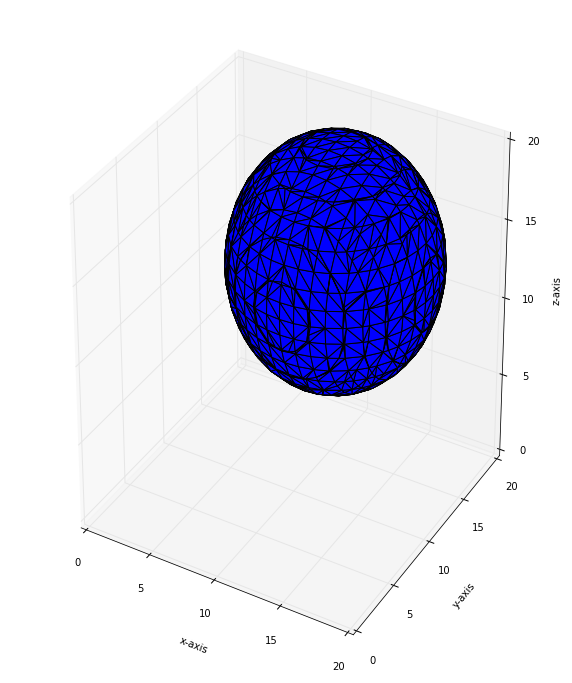

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-0, 20)  
ax.set_ylim(-0, 20)  
ax.set_zlim(-0, 20)  

plt.show()


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

ax.scatter(range(1,Newton_Desc.iterations+1),
           Newton_Desc.obj_array[0:Newton_Desc.iterations],marker='^',
           label='Non-Stochastic Newtons Method')
ax.scatter(range(1,Steepest_Desc.iterations+1),
           Steepest_Desc.obj_array[0:Steepest_Desc.iterations],marker='*',
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Objective Function over iterations')
plt.ylabel('F (w)')
plt.xlabel('Iteration')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

ax.scatter(range(1,(Newton_Desc.iterations)+1),
           Newton_Desc.obj_grad_array[0:Newton_Desc.iterations],
           marker='^',
           label='Non-Stochastic Newtons Method')

ax.scatter(range(1,(Steepest_Desc.iterations)+1),
           Steepest_Desc.obj_grad_array[0:Steepest_Desc.iterations],
           marker='*', 
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm over iterations')
plt.ylabel('norm(d/dw F (w))')
plt.xlabel('Iteration')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

ax.scatter(range(1,(Steepest_Desc.iterations)+1),
           Steepest_Desc.obj_grad_check_array[0:Steepest_Desc.iterations],
           marker='*',
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm and Approx. Gradient Norm Difference \n over iterations')
plt.ylabel('Difference')
plt.xlabel('Iteration')